In [34]:
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
from unyt import MWh, kWh

# PyPSA Network

In [35]:
n = pypsa.Network(name='Armourdale')

N_days=365
N_hours=24

index = pd.date_range(start="2018-01-01", 
                      periods=N_days*N_hours, 
                      freq='h')

n.set_snapshots(index)

Step 1: Add buses

In [36]:
bus_name = 'Residential'
n.add(class_name='Bus',
      name=bus_name,
      carrier='AC')

Step 2: Add energy carriers

In [37]:
n.add(class_name="Carrier", name="grid")
n.add(class_name="Carrier", name="solar")
n.add(class_name="Carrier", name="battery")
n.add(class_name="Carrier", name='net metering')

Step 3: Add load

In [38]:
load = pd.read_csv("../data/timeseries/residential_elec_load_rescaled.csv", parse_dates=True, index_col='timestamp')

In [39]:
load_resampled = load.loc['2018'].resample('h').mean().sum(axis=1)
load_resampled = load_resampled / 1e3  # kW --> MW

In [40]:
n.add(
    class_name="Load",
    name=f"Load {bus_name}",
    bus=bus_name,
    p_set=load_resampled
)

Step 3: Add weather data

In [41]:
weather = pd.read_csv("../data/timeseries/weather_year.csv", parse_dates=True, index_col=0)
weather.head()

,date_time,temp_db,rel_humidity,wind_speed,wind_direction,ghi,dni,dhi
2018-01-01 00:00:00,2005-01-01 01:00:00,8.0,61,5.7,80,0,0,0
2018-01-01 01:00:00,2005-01-01 02:00:00,8.0,57,5.1,90,0,0,0
2018-01-01 02:00:00,2005-01-01 03:00:00,8.0,57,5.1,90,0,0,0
2018-01-01 03:00:00,2005-01-01 04:00:00,7.0,56,6.2,80,0,0,0
2018-01-01 04:00:00,2005-01-01 05:00:00,7.0,56,5.1,90,0,0,0


In [42]:
# normalize GHI
ghi = weather['ghi'] / weather['ghi'].max()

Step 4: Upload cost data

In [43]:
costs = pd.read_csv("../data/technology_costs.csv", index_col='technology')

In [44]:
costs *= 1e3  # convert /kW to /MW
costs

,Fixed O&M,OCC
technology,,
DistributedWind,35912.100000,5.678577e+06
ResPV,28108.825392,2.630889e+06
Residential Battery Storage,78943.789878,3.157752e+06


Step 5: Add generators to network

In [45]:
def annuity(r, n):
    return r / (1 - 1 / (1 + r)**n)

In [46]:
annuity_adj = annuity(0.01, 20)
annuity_adj

0.05541531489055132

In [47]:
for generator in costs.index:
    if generator == 'DistributedWind':
        pass
    else:
        print(generator)
        annualized_cost = costs.at[generator, 'OCC']*annuity_adj + costs.at[generator,'Fixed O&M']
        print(annualized_cost)
        
        if generator=='ResPV':
            n.add(class_name='Generator',
                    name=generator,
                    bus=bus_name,
                    carrier="solar",
                    capital_cost=annualized_cost,  # $/kW
                    p_min_pu=ghi,
                    p_max_pu=ghi,
                    p_nom_extendable=True,
                    )
        elif generator=='Residential Battery Storage':
            pass
            # n.add(class_name="StorageUnit",
            #         name=generator,
            #         bus=bus_name,
            #         carrier="battery",
            #         capital_cost=annualized_cost,  # $/kW
            #         p_nom_extendable=True,
            #         max_hours=2.5,
            #         cyclic_state_of_charge=False,
            #         )
        
        

ResPV
173900.3569535663
Residential Battery Storage
253931.58886784827


Add a "net metering" technology to capture the excess energy.

In [48]:
retail_price = 112.9  # $/MWh

In [49]:
n.add(class_name="Generator",
      name=f"Net metering {bus_name}",
      bus=bus_name,
      carrier='net metering',
      p_min_pu=-1,
      p_max_pu=0.0,
      marginal_cost=retail_price*0.0,
      capital_cost=0.0,
      p_nom_extendable=True)

In [50]:
n.add(class_name='Generator',
      name='Evergy Import',
      bus=bus_name,
      carrier='grid',
      capital_cost=0,
      marginal_cost=retail_price,
      p_nom_extendable=True,
      # p_nom_max=1.3315
      )

In [51]:
n.generators

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
ResPV,Residential,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Net metering Residential,Residential,PQ,,0.0,0.0,True,0.0,inf,-1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Evergy Import,Residential,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


## Model Version: Baseline

At this moment, the model

* uses the sticker price for rooftop solar from NREL's ATB
* does NOT pay for net metering
* does NOT include residential storage

Step 6: Run the model

In [52]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 61.81it/s]
INFO:linopy.io: Writing time: 0.24s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61323 duals
Objective: 4.67e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [53]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Dispatch,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Generator,grid,1.430806,0.0,4135.96535,0.00000,4135.96535,0.0,0.329983,0.0,0.0,466950.487985,466950.487985,112.9
Load,-,0.000000,0.0,0.00000,4135.96535,-4135.96535,0.0,NaN,0.0,0.0,0.000000,-466950.487985,NaN


Step 7: Calculate the LCOE from the model

In [54]:
n.objective / n.loads_t.p_set.sum()

Load
Load Residential    112.9
dtype: float64

We observe that the model has an LCOE of $112.9/MWh, which makes sense because it only uses electricity purchased from the grid.

Step 8: Plot some data

In [55]:
TECH_ORDER = ['grid',
              'solar',
              'battery'
              ]

In [56]:
def power_by_carrier(n):
    p_by_carrier = n.generators_t.p.T.groupby(
        n.generators.carrier).sum().T 
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(
            n.storage_units.carrier).sum().T
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
        
    last_cols = [col for col in p_by_carrier.columns if col not in TECH_ORDER]

    p_by_carrier = p_by_carrier[TECH_ORDER+last_cols]

    return p_by_carrier

<Axes: xlabel='snapshot'>

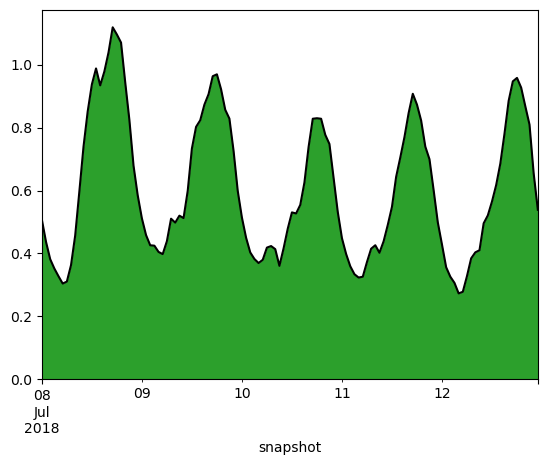

In [57]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)
# n.storage_units_t.p_store.loc[time].plot(ax=ax, legend=False)


## Model Version: Tax Credits

At this moment, the model

* reduces the price for rooftop solar by applying federal tax credits.
* does NOT pay for net metering
* does NOT include residential storage

Apply the Residential Renewable Energy Tax Credit

[DSIRE Data on the RRETC](https://programs.dsireusa.org/system/program/detail/1235/residential-renewable-energy-tax-credit) -- solar and storage each get a 30% tax credit. 

Apply the Investment Tax Credit (ITC)

[EPA Data on ITC](https://www.epa.gov/green-power-markets/summary-inflation-reduction-act-provisions-related-renewable-energy) -- qualified residential units in a low-income area recieve +20%.

[Homeowner's Guide to Federal Tax Credits](https://www.energy.gov/eere/solar/homeowners-guide-federal-tax-credit-solar-photovoltaics).

This will be implemented as a direct 50% cost reduction.

In [58]:
rretc_credit = 0.5

In [59]:
n.generators.loc['ResPV', 'capital_cost'] *= (1-rretc_credit)

In [60]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 60.89it/s]
INFO:linopy.io: Writing time: 0.23s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61323 duals
Objective: 4.17e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [61]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Optimal Capacity  Installed Capacity       Supply  \
Generator grid                  1.342852                 0.0  2964.049410   
          net metering          0.669086                 0.0     0.000000   
          solar                 0.947609                 0.0  1396.053259   
Load      -                     0.000000                 0.0     0.000000   

                        Withdrawal     Dispatch  Transmission  \
Generator grid             0.00000  2964.049410           0.0   
          net metering   224.13732  -224.137320           0.0   
          solar            0.00000  1396.053259           0.0   
Load      -             4135.96535 -4135.965350           0.0   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator grid                 0.251973  0.000000e+00               0.0000   
          net metering         0.038241  0.000000e+00               0.0000   
          solar                0.168178  3.914040e-10           82394.7361   
Load      -                         NaN  0.000000e+00               0.0000   

                        Operational Expenditure        Revenue  Market Value  
Generator grid                    334641.178424  334641.178424    112.900000  
          net metering                 0.000000       0.000000      0.000000  
          solar                        0.000000   82394.736100     59.019766  
Load      -                            0.000000 -417035.914525           NaN

Calculate the LCOE

In [62]:
model_lcoe_2 = n.objective / n.loads_t.p_set.sum()
model_lcoe_2

Load
Load Residential    100.831578
dtype: float64

Calculate the electricity price reduction

In [63]:
np.abs((100.831578 - 112.9)/112.9)*100

10.689479185119586

Looks like almost a 10.7% reduction in electricity cost.

<Axes: xlabel='snapshot'>

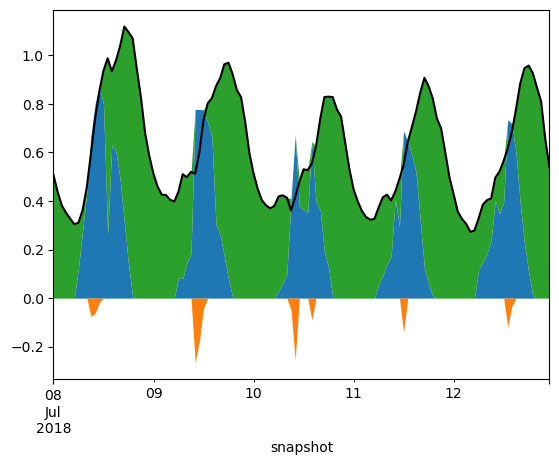

In [64]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)

## Model Version: Net Metering + Tax Credits

At this moment, the model

* reduces the price for rooftop solar by applying federal tax credits.
* Applies 50% retail price for net metering
* does NOT include residential storage

In [66]:
n.generators.marginal_cost

Generator
ResPV                         0.0
Net metering Residential      0.0
Evergy Import               112.9
Name: marginal_cost, dtype: float64

In [67]:
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*0.5

In [68]:
n.generators.marginal_cost

Generator
ResPV                         0.00
Net metering Residential     56.45
Evergy Import               112.90
Name: marginal_cost, dtype: float64

In [69]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 62.62it/s]
INFO:linopy.io: Writing time: 0.23s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61323 duals
Objective: 3.75e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [70]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Optimal Capacity  Installed Capacity       Supply  \
Generator grid                  1.322049                 0.0  2208.701032   
          net metering          4.032169                 0.0     0.000000   
          solar                 4.352297                 0.0  6411.970576   
Load      -                     0.000000                 0.0     0.000000   

                         Withdrawal     Dispatch  Transmission  \
Generator grid             0.000000  2208.701032           0.0   
          net metering  4484.706259 -4484.706259           0.0   
          solar            0.000000  6411.970576           0.0   
Load      -             4135.965350 -4135.965350           0.0   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator grid                 0.190715  0.000000e+00             0.000000   
          net metering         0.126967  0.000000e+00             0.000000   
          solar                0.168178  1.797677e-09        378433.000344   
Load      -                         NaN  0.000000e+00             0.000000   

                        Operational Expenditure        Revenue  Market Value  
Generator grid                    249362.346567  249362.346567    112.900000  
          net metering           -253161.668329 -253161.668329           NaN  
          solar                        0.000000  378433.000344     59.019766  
Load      -                            0.000000 -374633.678582           NaN

In [71]:
n.objective/n.loads_t.p_set.sum().values[0]

90.57950125390316

<Axes: xlabel='snapshot'>

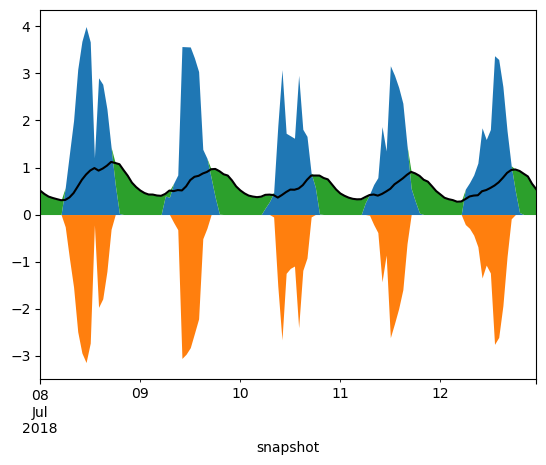

In [73]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)

## Model Version: Net Metering + Tax Credits

At this moment, the model

* reduces the price for rooftop solar by applying federal tax credits.
* Applies 90% retail price for net metering
* does NOT include residential storage

In [90]:
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*0.99

In [91]:
n.generators.marginal_cost

Generator
ResPV                         0.000
Net metering Residential    111.771
Evergy Import               112.900
Name: marginal_cost, dtype: float64

In [92]:
n.generators.loc['ResPV', 'p_nom_max'] = 2.807

In [93]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 57.13it/s]
INFO:linopy.io: Writing time: 0.25s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26283 primals, 61324 duals
Objective: 2.47e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [94]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Optimal Capacity  Installed Capacity       Supply  \
Generator grid                  1.331491                 0.0  2358.485524   
          net metering          2.505756                 0.0     0.000000   
          solar                 2.807000                 0.0  4135.379878   
Load      -                     0.000000                 0.0     0.000000   

                         Withdrawal     Dispatch  Transmission  \
Generator grid             0.000000  2358.485524           0.0   
          net metering  2357.900052 -2357.900052           0.0   
          solar            0.000000  4135.379878           0.0   
Load      -             4135.965350 -4135.965350           0.0   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator grid                 0.202205  0.000000e+00             0.000000   
          net metering         0.107419  0.000000e+00             0.000000   
          solar                0.168178  1.159408e-09        244069.150984   
Load      -                         NaN  0.000000e+00             0.000000   

                        Operational Expenditure        Revenue  Market Value  
Generator grid                    266273.015698  266273.015698    112.900000  
          net metering           -263544.846758 -263544.846758           NaN  
          solar                        0.000000  462664.672697    111.879606  
Load      -                            0.000000 -465392.841637           NaN

In [95]:
model_lcoe_3 = n.objective / n.loads_t.p_set.sum()
model_lcoe_3

Load
Load Residential    59.671032
dtype: float64

<Axes: xlabel='snapshot'>

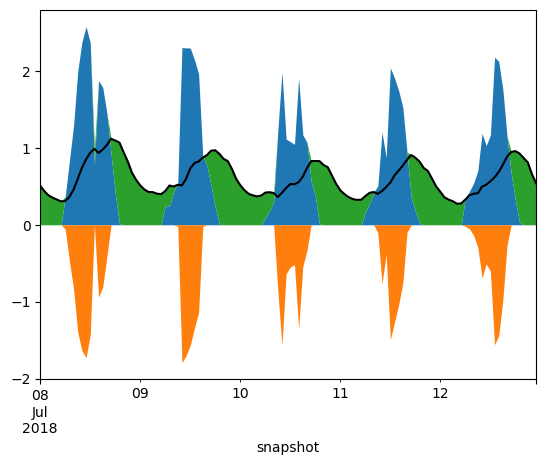

In [96]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)

In [41]:
rates = np.linspace(1e-4, 0.1, 10000)
y1 = annuity(rates, 20)
y2 = y1 / annuity(0.1,20)

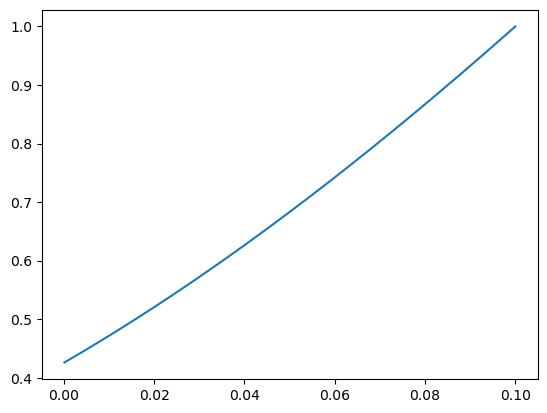

In [42]:
plt.plot(rates, y2)